# Motivation
In an attempt to kickstart this project, I wanted to try one of the most fundamental parts of this project: recognizing a Boggle board. 

# Setup
The cells below will help to set up this notebook. 

First, I'll configure the kernel. 

In [1]:
# Change directories to the root of the project
%cd ..

# Enable autoreload of modules
%load_ext autoreload
%autoreload 2

d:\data\programming\boggle-vision


Next, I'll load in some necessary libraries. 

In [2]:
# Import statements
import cv2
import pandas as pd
from pathlib import Path
import math
from matplotlib import pyplot as plt
import numpy as np

# Edge Detection
I found [this tutorial on using OpenCV for edge detection within images](https://learnopencv.com/edge-detection-using-opencv/). Here's some code I've adapted from it:  

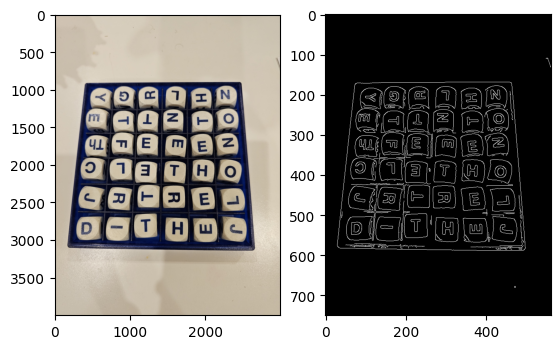

In [31]:
def apply_canny_edge_detection(img_path, resize_height=750,
                               return_original=False):
    """
    This function will load in an image, apply Canny Edge Detection to it,
    and then return the resulting image in the form of a NumPy array.
    """

    # Read the original image
    img = cv2.imread(img_path)

    # Resize the image to a reasonable size
    if resize_height is not None and img.shape[0] >= resize_height:
        scale = resize_height / img.shape[0]
        img = cv2.resize(img, (0, 0), fx=scale, fy=scale)

    # Convert to graycsale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Blur the image for better edge detection
    img_blur = cv2.GaussianBlur(img_gray, (3, 3), 0)

    # Canny Edge Detection
    edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)

    # Return the resulting image
    if not return_original:
        return edges
    else:
        return edges, img


def show_edge_detection(img_path):
    """
    This method will use Canny Edge Detection to find the edges of the image.
    Then, the original image and the edges will be plotted side-by-side using matplotlib.
    """
    
    # Load in the image
    img = cv2.imread(img_path)
    
    # Apply Canny Edge Detection
    edges = apply_canny_edge_detection(img_path)

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Plot images on subplots
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB))

    # Show figure
    plt.show()


# Show the edge detection for the easy-01.jpg image
show_edge_detection("data/test-pictures/easy-01.png")

With this, I can pretty easily detect the Boggle board from an image. What about if the angle is a little more skewed? 

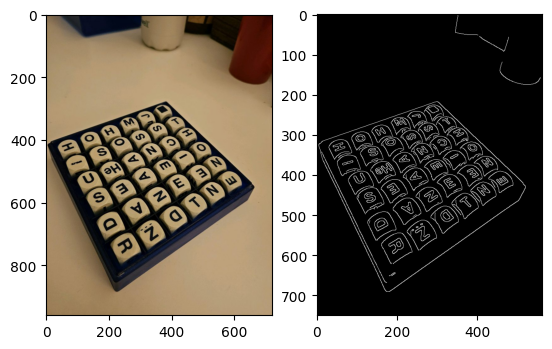

In [4]:
# Show the edge detection of the medium-01.png image
show_edge_detection("data/test-pictures/medium-01.png")

Seems like it still does this decently. I could probably apply some sort of shifting to the image to better align things. ChatGPT called this "perspective warping". 

# Perspective Transformation
Another tutorial to the rescue - [this one from TheAILearner](https://theailearner.com/tag/cv2-warpperspective/). This tutorial has you using `matplotlib` to manually select corner points, but... I think I can do a little better than that. [ChatGPT helped me](https://chat.openai.com/share/595f6911-27ce-4c1d-be5a-abf94050f983) write a "corner point detection" algorithm, and I used this in tandem with the Perspective Transformation tutorial. 

I'll start with that `detect_corner_points` method:

In [6]:
def detect_corner_points(image_path):
    """
    This function takes an image path as input and returns the corner points of the Boggle board. 
    """
    
    # Apply Canny edge detection to the image
    edges = apply_canny_edge_detection(image_path)

    # Find the contours in the image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort the contours by area in descending order and keep the largest one
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

    # Approximate the contour with a 4-point polygon
    epsilon = 0.02 * cv2.arcLength(contours[0], True)
    approx = cv2.approxPolyDP(contours[0], epsilon, True)

    # The corner points are the four points of the approximated polygon
    corner_points = approx.reshape(4, 2).astype(np.float32)
    
    # Return the corner points
    return corner_points

Next, I'm going to use this to transform the perspective of the image: 

In [34]:
def warp_perspective_to_top_down(image_path, 
                                 return_edges=True,
                                 return_original=False):
    """
    This method will automatically detect the corners of a Boggle board, and then
    shift the perspective so that the board is flat.
    """

    # Load in the image, and apply Canny edge detection
    edges, original = apply_canny_edge_detection(image_path, return_original=True)
    corner_points = detect_corner_points(image_path)

    # Unpack the corner points
    pt_A, pt_B, pt_C, pt_D = corner_points

    # Use the L2 norm to calculate the width and height of the new image
    width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
    width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
    maxWidth = max(int(width_AD), int(width_BC))
    height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
    height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
    maxHeight = max(int(height_AB), int(height_CD))

    # Compute the perspective transform matrix
    input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
    output_pts = np.float32(
        [[0, 0], [0, maxHeight - 1], [maxWidth - 1, maxHeight - 1], [maxWidth - 1, 0]]
    )
    M = cv2.getPerspectiveTransform(input_pts, output_pts)

    # Apply cv2's warpPerspective to get the top-down view of the image
    if return_original:
        out = cv2.warpPerspective(original, M, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)
    else:
        out = cv2.warpPerspective(edges, M, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)
    
    # Return the top-down image
    return out

With the aforementioned methods, I should be able to run this perspective shifting. 

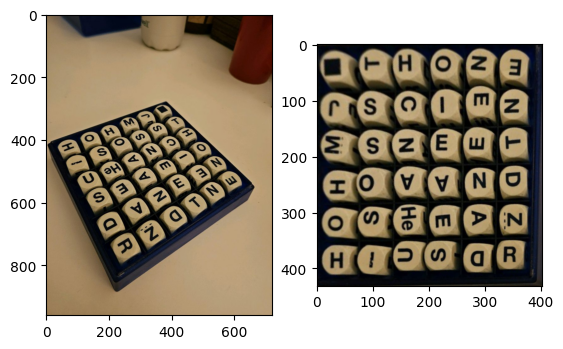

In [36]:
def show_top_down_perspective(image_path, show_original=False):
    """
    This function shows the warped perspective of an image.
    """
    
    # Show the warped image
    img = cv2.imread(image_path)
    warped_perspective_img = warp_perspective_to_top_down(image_path, return_original=show_original)

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Plot images on subplots
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(warped_perspective_img, cv2.COLOR_BGR2RGB))

    # Show figure
    plt.show()

# Show the warped perspective of an image
show_top_down_perspective("data/test-pictures/medium-01.png", show_original=True)

It seems to work well enough!

# Segmenting Boards Into Letters
The next step: now that I can somewhat accurately detect a Boggle board, I want to try and detect the letters within. I asked ChatGPT for some help with this; the first (naive) solution is to simply cut your image up into evenly sized square cells: 

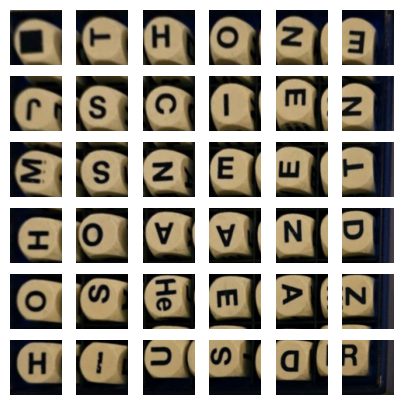

In [47]:
def segment_into_cells(image, grid_size=6):
    # Calculate the width and height of each cell
    cell_height, cell_width = image.shape[0] // grid_size, image.shape[1] // grid_size

    cells = []
    for i in range(grid_size):
        for j in range(grid_size):
            # Slice the image into a cell
            cell = image[i*cell_height:(i+1)*cell_height, j*cell_width:(j+1)*cell_width]
            cells.append(cell)
            
    return cells

def display_cells(cells, grid_size=6):
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))

    for i in range(grid_size):
        for j in range(grid_size):
            # Calculate the index of the cell in the flat list
            index = i * grid_size + j
            
            # Display the cell in the appropriate subplot
            axs[i, j].imshow(cv2.cvtColor(cells[index], cv2.COLOR_BGR2RGB))
            axs[i, j].axis('off')  # Hide axis

    plt.show()

# Assume image is the corrected, top-down view of the board
image = warp_perspective_to_top_down('data/test-pictures/medium-01.png', return_original=True)
cells = segment_into_cells(image)
display_cells(cells)

This works... surprisingly well. I think that I could try and use some [contour detection](https://learnopencv.com/contour-detection-using-opencv-python-c/#Finding-and-Drawing-Contours-using-OpenCV) to try and better extract the letters from this. 

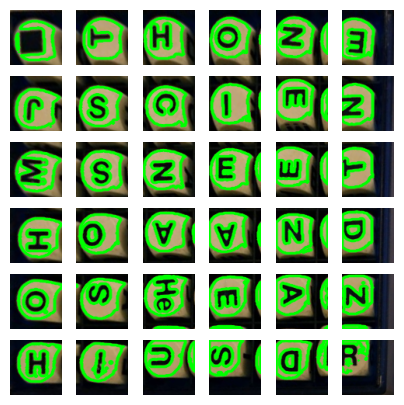

In [48]:
def draw_contours_on_image(image):
    """
    This method will transform an image by overlaying the detected 
    contours on top of the image. The contours will be drawn in 
    green with a thickness of 2.
    """
    
    # Greyscale the image 
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # apply binary thresholding
    ret, thresh = cv2.threshold(img_gray, 150, 255, cv2.THRESH_BINARY)

    # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
    contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
                                        
    # draw contours on the original image
    cv2.drawContours(image=image, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
    
    # Return the image with the contours drawn on it
    return image

# Iterate through all of the cells, and detect the contours in each image 
cells_with_contours = []
for cell in cells:
    cells_with_contours.append(draw_contours_on_image(cell))

display_cells(cells_with_contours)

# OCR'ing Letters
Now that I can slice the image up into letters, I wanted to know: could I easily / naively use an OCR tool like Tesseract to detect the actual letters from the images? 

If this approach worked, then I wouldn't need to label a bunch of data. 

In [15]:
import cv2
import pytesseract
from PIL import Image

# Load the image
image = cells[-1]

# Threshold the image to get a binary image
_, image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Create a PIL Image object for pytesseract
image_pil = Image.fromarray(image)

# Run OCR on the image
text = pytesseract.image_to_string(image_pil, config='--psm 10')

print('Recognized text:', text)


Recognized text: By



In [13]:
best_text = ''
best_confidence = -np.inf

for angle in range(360):
    # Rotate the image
    rotated_image_pil = image_pil.rotate(angle)

    # Run OCR on the rotated image
    text = pytesseract.image_to_string(rotated_image_pil, config='--psm 10')

    # Get the confidence of the OCR result
    confidence = pytesseract.image_to_string(rotated_image_pil, config='--psm 10 -c tessedit_create_txt=1')
    
    print(f"Predicted {text} with confidence {confidence}")

    # If this result is more confident than the best so far, keep it
    if confidence > best_confidence:
        best_text = text
        best_confidence = confidence

print('Best recognized text:', best_text)

Predicted (Fi
 with confidence (Fi



TypeError: '>' not supported between instances of 'str' and 'float'